<a href="https://colab.research.google.com/github/alyrazik/802.11/blob/main/uncover_wifi_station_identity_despite_randomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
%matplotlib inline

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
df_x = pd.read_pickle(r'/content/drive/MyDrive/Network dataset/x_file_3')
# df_x = pd.read_pickle(r'/content/drive/MyDrive/Network dataset/x_total')
# df_1 = pd.read_json('/content/drive/MyDrive/Network dataset/part1.json')
# df_2 = pd.read_json('/content/drive/MyDrive/Network dataset/part2.json')
# df_3 = pd.read_json('/content/drive/MyDrive/Network dataset/part3.json')
# df_1 = pd.json_normalize(df_1['_source'])
# df_2 = pd.json_normalize(df_2['_source'])
# df_3 = pd.json_normalize(df_3['_source'])
# df_x = pd.concat((df_x, df_1, df_2, df_3))

In [82]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14159 entries, 0 to 14158
Columns: 107 entries, frame.frame_frame_interface_id to wlan_wlan_mgt.wlan_wlan_supported_rates
dtypes: bool(32), object(75)
memory usage: 8.5+ MB


In [83]:
'''
for i in range(len(df_x.columns)):
  if 'id' in df_x.columns[i]:
    print(i)
'''

"\nfor i in range(len(df_x.columns)):\n  if 'id' in df_x.columns[i]:\n    print(i)\n"

In [84]:
df_y = pd.read_pickle(r'/content/drive/MyDrive/Network dataset/y_file_3')
# df_y = pd.read_pickle(r'/content/drive/MyDrive/Network dataset/y_total')

In [85]:
df_y = pd.DataFrame(df_y)

In [86]:
df_y.head()

,source_address
0,68:e7:c2:f8:0d:f1
1,68:e7:c2:f8:0d:f1
2,68:e7:c2:f8:0d:f1
3,00:0c:e7:56:44:8e
4,00:0c:e7:56:44:8e


In [87]:
df_y['fake'] = df_y['source_address'].astype(str).apply(lambda x: x[1] == '2' or x[1] =='6' or x[1]=='a' or x[1]=='e')

In [88]:
df_y['fake'].value_counts()

False    14159
Name: fake, dtype: int64

In [89]:
df_y[df_y['fake']==False].nunique()

source_address    1728
fake                 1
dtype: int64

In [90]:
temp_df = pd.DataFrame(df_y['source_address'].value_counts()).reset_index()
temp_df[temp_df['source_address'] >= 50].info() # 100 source address that had sent more than 50 probe requests.
devices_list = list(temp_df[temp_df['source_address'] >= 50]['index'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           51 non-null     object
 1   source_address  51 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [91]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14159 entries, 0 to 14158
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source_address  14159 non-null  object
 1   fake            14159 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 124.6+ KB


In [92]:
df_x = df_x[df_y['source_address'].isin(devices_list)]
df_y = df_y[df_y['source_address'].isin(devices_list)]

In [93]:
# Now both df_x and df_y have ~12K records of devices (and 106 columns) that had at least sent 50 probe requests.

In [94]:
df_x.head()

,frame.frame_frame_interface_id,frame.frame_frame_interface_name,frame.frame_frame_encap_type,frame.frame_frame_time,frame.frame_frame_offset_shift,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_delta_displayed,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,frame.frame_frame_marked,frame.frame_frame_ignored,frame.frame_frame_protocols,radiotap.radiotap_radiotap_version,radiotap.radiotap_radiotap_pad,radiotap.radiotap_radiotap_length,radiotap.radiotap_radiotap_present_word,radiotap.radiotap_radiotap_present_tsft,radiotap.radiotap_radiotap_present_flags,radiotap.radiotap_radiotap_present_rate,radiotap.radiotap_radiotap_present_channel,radiotap.radiotap_radiotap_present_fhss,radiotap.radiotap_radiotap_present_dbm_antsignal,radiotap.radiotap_radiotap_present_dbm_antnoise,radiotap.radiotap_radiotap_present_lock_quality,radiotap.radiotap_radiotap_present_tx_attenuation,radiotap.radiotap_radiotap_present_db_tx_attenuation,radiotap.radiotap_radiotap_present_dbm_tx_power,radiotap.radiotap_radiotap_present_antenna,radiotap.radiotap_radiotap_present_db_antsignal,radiotap.radiotap_radiotap_present_db_antnoise,radiotap.radiotap_radiotap_present_rxflags,radiotap.radiotap_radiotap_present_txflags,radiotap.radiotap_radiotap_present_xchannel,radiotap.radiotap_radiotap_present_mcs,radiotap.radiotap_radiotap_present_ampdu,radiotap.radiotap_radiotap_present_vht,radiotap.radiotap_radiotap_present_timestamp,...,radiotap.radiotap_radiotap_channel_flags_gfsk,radiotap.radiotap_radiotap_channel_flags_gsm,radiotap.radiotap_radiotap_channel_flags_sturbo,radiotap.radiotap_radiotap_channel_flags_half,radiotap.radiotap_radiotap_channel_flags_quarter,radiotap.radiotap_radiotap_dbm_antsignal,radiotap.radiotap_radiotap_rxflags,radiotap.radiotap_radiotap_rxflags_badplcp,radiotap.radiotap_radiotap_antenna,wlan_radio.wlan_radio_wlan_radio_phy,wlan_radio.wlan_radio_wlan_radio_short_preamble,wlan_radio.wlan_radio_wlan_radio_data_rate,wlan_radio.wlan_radio_wlan_radio_channel,wlan_radio.wlan_radio_wlan_radio_frequency,wlan_radio.wlan_radio_wlan_radio_signal_dbm,wlan_radio.wlan_radio_wlan_radio_duration,wlan_radio.wlan_radio_wlan_radio_preamble,wlan.wlan_wlan_fc_type_subtype,wlan.wlan_wlan_fc,wlan.wlan_wlan_fc_version,wlan.wlan_wlan_fc_type,wlan.wlan_wlan_fc_subtype,wlan.wlan_wlan_flags,wlan.wlan_wlan_fc_ds,wlan.wlan_wlan_fc_tods,wlan.wlan_wlan_fc_fromds,wlan.wlan_wlan_fc_frag,wlan.wlan_wlan_fc_retry,wlan.wlan_wlan_fc_pwrmgt,wlan.wlan_wlan_fc_moredata,wlan.wlan_wlan_fc_protected,wlan.wlan_wlan_fc_order,wlan.wlan_wlan_duration,wlan.wlan_wlan_frag,wlan.wlan_wlan_seq,wlan_wlan_mgt.wlan_wlan_tag,wlan_wlan_mgt.wlan_wlan_tag_number,wlan_wlan_mgt.wlan_wlan_tag_length,wlan_wlan_mgt.wlan_wlan_ssid,wlan_wlan_mgt.wlan_wlan_supported_rates
0,0,wlan1,23,2021-06-04T18:33:39.641993378Z,0.000000000,1622831619.641993378,0.000000000,0.000000000,0.000000000,1,111,111,False,False,radiotap:wlan_radio:wlan,0,0,24,"[0xa000402e, 0x00000820]","[False, False]","[True, False]","[True, False]","[True, False]","[False, False]","[True, True]","[False, False]","[False, False]","[False, False]","[False, False]","[False, False]","[False, True]","[False, False]","[False, False]","[True, False]","[False, False]","[False, False]","[False, False]","[False, False]","[False, False]","[False, False]",...,False,False,False,False,False,"[-77, -77]",0x00000000,False,0,4,False,1,9,2452,-77,888,192,4,0x00004000,0,0,4,0x00000000,0x00000000,False,False,False,False,False,False,False,False,0,0,3914,"[None, None, None, None, None, None]","[0, 1, 50, 3, 45, 221]","[5, 4, 8, 1, 26, 7]",kenzY,"[2, 4, 11, 22]"
1,0,wlan1,23,2021-06-04T18:33:39.670048342Z,0.000000000,1622831619.670048342,0.028054964,0.028054964,0.028054964,2,111,111,False,False,radiotap:wlan_radio:wlan,0,0,24,"[0xa000402e, 0x00000820]","[False, False]","[True, False]","[True, False]","[True, False]","[False, False]","[True, True]","[False, False]","[False, False]","

In [95]:
list_cols = []
for c in df_x.columns:
  if type(df_x[c][0]) == list:
    list_cols.append(c)

In [96]:
	# df_x['wlan_wlan_mgt.wlan_wlan_tag_number'].to_list()

In [21]:
# for c in list_cols:
#   col_dummy = pd.DataFrame(df_x[c].to_list(), columns=[c for c in df_x[c].to_list()])
#   df_x = df_x.drop(c, axis=1)
#   df_x = pd.concat((df_x, col_dummy), axis=1)

In [97]:
df_x.drop(list_cols, axis=1, inplace=True) # remove these columns

In [98]:
dropped_cols = []
for c in (df_x.columns):
  if df_x[c].nunique() <= 1:
    dropped_cols.append(c)


### Note: 58 columns with no entropy. to be dropped

In [99]:
df_x.drop(dropped_cols, axis=1, inplace=True) 
# df_x.drop('layers.wlan.wlan.ra', axis=1, inplace=True)
# df_x.drop('destination_address', axis=1, inplace=True)


In [100]:
other_cols = ['frame.frame_frame_time', 'frame.frame_frame_time_delta_displayed']
df_x.drop(other_cols, axis=1, inplace=True)

In [101]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5959 entries, 0 to 14157
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   frame.frame_frame_time_epoch                   5959 non-null   object
 1   frame.frame_frame_time_delta                   5959 non-null   object
 2   frame.frame_frame_time_relative                5959 non-null   object
 3   frame.frame_frame_number                       5959 non-null   object
 4   frame.frame_frame_len                          5959 non-null   object
 5   frame.frame_frame_cap_len                      5959 non-null   object
 6   radiotap.radiotap_radiotap_datarate            5959 non-null   object
 7   radiotap.radiotap_radiotap_channel_freq        5959 non-null   object
 8   radiotap.radiotap_radiotap_channel_flags       5959 non-null   object
 9   radiotap.radiotap_radiotap_channel_flags_cck   5959 non-null  

In [102]:
df_x.head()

,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,radiotap.radiotap_radiotap_datarate,radiotap.radiotap_radiotap_channel_freq,radiotap.radiotap_radiotap_channel_flags,radiotap.radiotap_radiotap_channel_flags_cck,radiotap.radiotap_radiotap_channel_flags_ofdm,wlan_radio.wlan_radio_wlan_radio_phy,wlan_radio.wlan_radio_wlan_radio_data_rate,wlan_radio.wlan_radio_wlan_radio_channel,wlan_radio.wlan_radio_wlan_radio_frequency,wlan_radio.wlan_radio_wlan_radio_signal_dbm,wlan_radio.wlan_radio_wlan_radio_duration,wlan_radio.wlan_radio_wlan_radio_preamble,wlan.wlan_wlan_fc,wlan.wlan_wlan_flags,wlan.wlan_wlan_fc_retry,wlan.wlan_wlan_duration,wlan.wlan_wlan_seq,wlan_wlan_mgt.wlan_wlan_ssid
0,1622831619.641993378,0.000000000,0.000000000,1,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-77,888,192,0x00004000,0x00000000,False,0,3914,kenzY
1,1622831619.670048342,0.028054964,0.028054964,2,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-79,888,192,0x00004000,0x00000000,False,0,3918,KenzY
2,1622831619.672104797,0.002056455,0.030111419,3,117,117,1,2452,0x000000a0,True,False,4,1,9,2452,-77,936,192,0x00004000,0x00000000,False,0,3920,ROJA WALLID
8,1622831621.074082881,0.695290480,1.432089503,9,78,78,1,2437,0x000000a0,True,False,4,1,6,2437,-75,624,192,0x00004000,0x00000000,False,0,2066,
14,1622831625.361382347,0.044205010,5.719388969,15,106,106,1,2412,0x000000a0,True,False,4,1,1,2412,-69,848,192,0x00004000,0x00000000,False,0,3935,


In [28]:
# df_x['frame.frame_frame_time'] = df_x['frame.frame_frame_time'].str.replace(" Egypt Standard Time","")
# df_x['frame.frame_frame_time'] = df_x['frame.frame_frame_time'].str.replace("Jun  4, 2021 ","")

In [29]:
# df_x['frame.frame_frame_time'] = df_x['frame.frame_frame_time'].apply(lambda x: int(x.split(':')[0])*3600 + int(x.split(':')[1])*60 + float(x.split(':')[2]))

In [30]:
# df_x.drop('layers.frame.frame_time', axis=1, inplace=True)  # dropping time for now, will retain it later

In [31]:
'''
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df_x.select_dtypes(include=numerics).columns
'''

"\nnumerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']\nnumeric_columns = df_x.select_dtypes(include=numerics).columns\n"

In [32]:
'''
hex_numeric_cols = ['layers.radiotap.radiotap.channel.flags', \
'layers.wlan.wlan.fc', 'layers.wlan.wlan.fc_tree.wlan.flags']  # , 'layers.radiotap.radiotap.flags', 'layers.wlan.wlan.fc_tree.wlan.flags', 'layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.ds'
'''

"\nhex_numeric_cols = ['layers.radiotap.radiotap.channel.flags', 'layers.wlan.wlan.fc', 'layers.wlan.wlan.fc_tree.wlan.flags']  # , 'layers.radiotap.radiotap.flags', 'layers.wlan.wlan.fc_tree.wlan.flags', 'layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.ds'\n"

In [33]:
# df_x.drop(hex_numeric_cols, axis=1, inplace=True)  # dropping for now, will retain it later

In [34]:
# bool_cols = ['wlan.wlan_wlan_fc_retry', 'radiotap.radiotap_radiotap_channel_flags_cck', 'radiotap.radiotap_radiotap_channel_flags_ofdm']

In [35]:
type(df_x.columns)

pandas.core.indexes.base.Index

In [36]:
df_x.head()

,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,radiotap.radiotap_radiotap_datarate,radiotap.radiotap_radiotap_channel_freq,radiotap.radiotap_radiotap_channel_flags,radiotap.radiotap_radiotap_channel_flags_cck,radiotap.radiotap_radiotap_channel_flags_ofdm,wlan_radio.wlan_radio_wlan_radio_phy,wlan_radio.wlan_radio_wlan_radio_data_rate,wlan_radio.wlan_radio_wlan_radio_channel,wlan_radio.wlan_radio_wlan_radio_frequency,wlan_radio.wlan_radio_wlan_radio_signal_dbm,wlan_radio.wlan_radio_wlan_radio_duration,wlan_radio.wlan_radio_wlan_radio_preamble,wlan.wlan_wlan_fc,wlan.wlan_wlan_flags,wlan.wlan_wlan_fc_retry,wlan.wlan_wlan_duration,wlan.wlan_wlan_seq,wlan_wlan_mgt.wlan_wlan_ssid
0,1622831619.641993378,0.000000000,0.000000000,1,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-77,888,192,0x00004000,0x00000000,False,0,3914,kenzY
1,1622831619.670048342,0.028054964,0.028054964,2,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-79,888,192,0x00004000,0x00000000,False,0,3918,KenzY
2,1622831619.672104797,0.002056455,0.030111419,3,117,117,1,2452,0x000000a0,True,False,4,1,9,2452,-77,936,192,0x00004000,0x00000000,False,0,3920,ROJA WALLID
8,1622831621.074082881,0.695290480,1.432089503,9,78,78,1,2437,0x000000a0,True,False,4,1,6,2437,-75,624,192,0x00004000,0x00000000,False,0,2066,
14,1622831625.361382347,0.044205010,5.719388969,15,106,106,1,2412,0x000000a0,True,False,4,1,1,2412,-69,848,192,0x00004000,0x00000000,False,0,3935,


In [103]:
# cat_cols = [x for x in df_x.columns.tolist() if x not in (bool_cols + other_cols)]
df_x.drop('wlan_wlan_mgt.wlan_wlan_ssid', axis=1, inplace=True)
cat_cols = ['radiotap.radiotap_radiotap_channel_flags', 'wlan.wlan_wlan_fc', 'wlan.wlan_wlan_flags'] # 'wlan_wlan_mgt.wlan_wlan_ssid'

In [38]:
# cat_cols = [c for c in df_x.columns if c not in numeric_columns] # 'layers.frame.frame.protocols'
# cat_cols = ['layers.radiotap.radiotap.channel.flags', 'layers.wlan.wlan.fc', 'layers.wlan.wlan.fc_tree.wlan.flags']

In [104]:
df_x.head()

,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,radiotap.radiotap_radiotap_datarate,radiotap.radiotap_radiotap_channel_freq,radiotap.radiotap_radiotap_channel_flags,radiotap.radiotap_radiotap_channel_flags_cck,radiotap.radiotap_radiotap_channel_flags_ofdm,wlan_radio.wlan_radio_wlan_radio_phy,wlan_radio.wlan_radio_wlan_radio_data_rate,wlan_radio.wlan_radio_wlan_radio_channel,wlan_radio.wlan_radio_wlan_radio_frequency,wlan_radio.wlan_radio_wlan_radio_signal_dbm,wlan_radio.wlan_radio_wlan_radio_duration,wlan_radio.wlan_radio_wlan_radio_preamble,wlan.wlan_wlan_fc,wlan.wlan_wlan_flags,wlan.wlan_wlan_fc_retry,wlan.wlan_wlan_duration,wlan.wlan_wlan_seq
0,1622831619.641993378,0.000000000,0.000000000,1,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-77,888,192,0x00004000,0x00000000,False,0,3914
1,1622831619.670048342,0.028054964,0.028054964,2,111,111,1,2452,0x000000a0,True,False,4,1,9,2452,-79,888,192,0x00004000,0x00000000,False,0,3918
2,1622831619.672104797,0.002056455,0.030111419,3,117,117,1,2452,0x000000a0,True,False,4,1,9,2452,-77,936,192,0x00004000,0x00000000,False,0,3920
8,1622831621.074082881,0.695290480,1.432089503,9,78,78,1,2437,0x000000a0,True,False,4,1,6,2437,-75,624,192,0x00004000,0x00000000,False,0,2066
14,1622831625.361382347,0.044205010,5.719388969,15,106,106,1,2412,0x000000a0,True,False,4,1,1,2412,-69,848,192,0x00004000,0x00000000,False,0,3935


In [105]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5959 entries, 0 to 14157
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   frame.frame_frame_time_epoch                   5959 non-null   object
 1   frame.frame_frame_time_delta                   5959 non-null   object
 2   frame.frame_frame_time_relative                5959 non-null   object
 3   frame.frame_frame_number                       5959 non-null   object
 4   frame.frame_frame_len                          5959 non-null   object
 5   frame.frame_frame_cap_len                      5959 non-null   object
 6   radiotap.radiotap_radiotap_datarate            5959 non-null   object
 7   radiotap.radiotap_radiotap_channel_freq        5959 non-null   object
 8   radiotap.radiotap_radiotap_channel_flags       5959 non-null   object
 9   radiotap.radiotap_radiotap_channel_flags_cck   5959 non-null  

In [106]:
for c in cat_cols:
     col_dummy = pd.get_dummies(df_x[c], prefix=c)
     df_x = df_x.drop(c, axis=1)
     df_x = pd.concat((df_x, col_dummy), axis=1)

In [107]:
df_x.head()

,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,radiotap.radiotap_radiotap_datarate,radiotap.radiotap_radiotap_channel_freq,radiotap.radiotap_radiotap_channel_flags_cck,radiotap.radiotap_radiotap_channel_flags_ofdm,wlan_radio.wlan_radio_wlan_radio_phy,wlan_radio.wlan_radio_wlan_radio_data_rate,wlan_radio.wlan_radio_wlan_radio_channel,wlan_radio.wlan_radio_wlan_radio_frequency,wlan_radio.wlan_radio_wlan_radio_signal_dbm,wlan_radio.wlan_radio_wlan_radio_duration,wlan_radio.wlan_radio_wlan_radio_preamble,wlan.wlan_wlan_fc_retry,wlan.wlan_wlan_duration,wlan.wlan_wlan_seq,radiotap.radiotap_radiotap_channel_flags_0x000000a0,radiotap.radiotap_radiotap_channel_flags_0x000000c0,wlan.wlan_wlan_fc_0x00004000,wlan.wlan_wlan_fc_0x00004008,wlan.wlan_wlan_flags_0x00000000,wlan.wlan_wlan_flags_0x00000008
0,1622831619.641993378,0.000000000,0.000000000,1,111,111,1,2452,True,False,4,1,9,2452,-77,888,192,False,0,3914,1,0,1,0,1,0
1,1622831619.670048342,0.028054964,0.028054964,2,111,111,1,2452,True,False,4,1,9,2452,-79,888,192,False,0,3918,1,0,1,0,1,0
2,1622831619.672104797,0.002056455,0.030111419,3,117,117,1,2452,True,False,4,1,9,2452,-77,936,192,False,0,3920,1,0,1,0,1,0
8,1622831621.074082881,0.695290480,1.432089503,9,78,78,1,2437,True,False,4,1,6,2437,-75,624,192,False,0,2066,1,0,1,0,1,0
14,1622831625.361382347,0.044205010,5.719388969,15,106,106,1,2412,True,False,4,1,1,2412,-69,848,192,False,0,3935,1,0,1,0,1,0


In [108]:
for c in df_x.columns:
  df_x[c] = df_x[c].astype(float)

In [109]:
df = df_x[df_y['fake'] == False]
df_labels = df_y[df_y['fake'] == False].iloc[:, 0]

In [110]:
data = df.to_numpy()
labels = df_labels.to_numpy()

In [111]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(data, labels, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=1)


# Data
X_train, y_train for training (70% of data) <br>
X-val, y_val for validation (20% of data) <br>
X_test, y_test for testing (10% of data) <br>

In [112]:
xgb_1 = XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0, 
                    use_label_encoder=True, eval_metric='logloss')

In [113]:
y_val_pred = xgb_1.fit(X_train, y_train).predict(X_val)


In [114]:
print("Number of mislabeled points out of a total %d points : %d"% (X_val.shape[0], (y_val != y_val_pred).sum()))

Number of mislabeled points out of a total 1073 points : 99


In [115]:
print(f"Classifier Report : \n\n {classification_report(y_val, y_val_pred)}") #not all classes are (well) represented in test set.

Classifier Report : 

                    precision    recall  f1-score   support

0c:2c:54:7e:c9:3d       0.80      0.94      0.86        17
0c:b3:19:5c:00:47       0.87      0.93      0.90        28
14:5f:94:fc:7e:97       1.00      0.83      0.91         6
18:19:d6:7f:8f:6c       1.00      0.70      0.82        10
1c:02:19:00:ac:af       0.90      0.90      0.90        10
20:2d:07:6f:b4:30       0.90      1.00      0.95        18
20:f4:78:63:64:aa       1.00      0.82      0.90        11
28:16:7f:20:3a:c1       1.00      0.80      0.89        10
30:84:54:f1:b9:5f       1.00      0.64      0.78        14
44:01:bb:4c:e5:3d       0.92      0.90      0.91        86
44:66:fc:2c:c3:05       0.92      0.88      0.90        26
44:66:fc:ba:b4:4d       1.00      0.94      0.97        18
48:88:ca:c8:81:44       1.00      1.00      1.00        20
50:3c:ea:78:e5:81       0.62      0.81      0.70        32
5c:66:6c:df:2f:b7       0.87      1.00      0.93        13
68:e7:c2:f8:0d:f1       0.95    

In [116]:
importance = (xgb_1.feature_importances_)

In [117]:
important_features = (df_x.columns[list(np.argsort(importance))[::-1]]).tolist()


In [132]:
important_features[:6]

['wlan_radio.wlan_radio_wlan_radio_data_rate',
 'frame.frame_frame_cap_len',
 'frame.frame_frame_len',
 'wlan_radio.wlan_radio_wlan_radio_duration',
 'frame.frame_frame_time_relative',
 'frame.frame_frame_time_epoch']

In [135]:
importance_scores = list(np.sort(importance))[::-1]
importance_scores

[0.24621809,
 0.22954626,
 0.120554715,
 0.09202601,
 0.050928164,
 0.04612419,
 0.042903196,
 0.038728572,
 0.034067668,
 0.027750093,
 0.025527602,
 0.015746847,
 0.013451807,
 0.012748384,
 0.0036783381,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [120]:
filtered_features = [x for x in important_features if 'wlan_wlan_mgt.wlan_wlan_ssid' not in x]

In [121]:
filtered_features

['wlan_radio.wlan_radio_wlan_radio_data_rate',
 'frame.frame_frame_cap_len',
 'frame.frame_frame_len',
 'wlan_radio.wlan_radio_wlan_radio_duration',
 'frame.frame_frame_time_relative',
 'frame.frame_frame_time_epoch',
 'radiotap.radiotap_radiotap_datarate',
 'frame.frame_frame_number',
 'wlan_radio.wlan_radio_wlan_radio_signal_dbm',
 'wlan.wlan_wlan_seq',
 'radiotap.radiotap_radiotap_channel_freq',
 'frame.frame_frame_time_delta',
 'wlan_radio.wlan_radio_wlan_radio_channel',
 'wlan_radio.wlan_radio_wlan_radio_frequency',
 'radiotap.radiotap_radiotap_channel_flags_cck',
 'wlan.wlan_wlan_flags_0x00000000',
 'wlan_radio.wlan_radio_wlan_radio_phy',
 'radiotap.radiotap_radiotap_channel_flags_ofdm',
 'wlan_radio.wlan_radio_wlan_radio_preamble',
 'wlan.wlan_wlan_fc_retry',
 'wlan.wlan_wlan_duration',
 'radiotap.radiotap_radiotap_channel_flags_0x000000a0',
 'radiotap.radiotap_radiotap_channel_flags_0x000000c0',
 'wlan.wlan_wlan_fc_0x00004000',
 'wlan.wlan_wlan_fc_0x00004008',
 'wlan.wlan_wlan_

In [122]:
l = ['wlan_wlan_mgt.wlan_wlan_ssid'] + (filtered_features[:5])

In [123]:
print(l)

['wlan_wlan_mgt.wlan_wlan_ssid', 'wlan_radio.wlan_radio_wlan_radio_data_rate', 'frame.frame_frame_cap_len', 'frame.frame_frame_len', 'wlan_radio.wlan_radio_wlan_radio_duration', 'frame.frame_frame_time_relative']


In [124]:
importance

array([0.04612419, 0.01574685, 0.05092816, 0.03872857, 0.12055472,
       0.22954626, 0.0429032 , 0.0255276 , 0.00367834, 0.        ,
       0.        , 0.24621809, 0.01345181, 0.01274838, 0.03406767,
       0.09202601, 0.        , 0.        , 0.        , 0.02775009,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

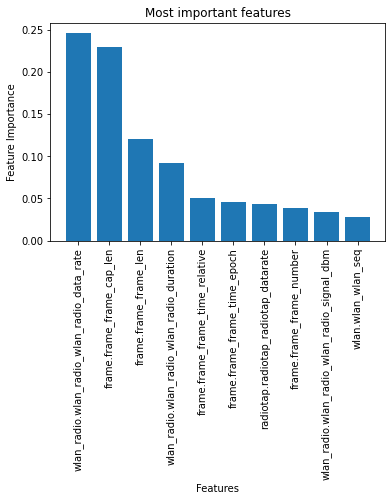

In [140]:
# plot
#plt.bar(range(len(xgb_1.feature_importances_)), xgb_1.feature_importances_)
plt.bar(important_features[:10], importance_scores[:10])
plt.xlabel('Features')
plt.ylabel('Feature Importance');
locs, labels = plt.xticks()
plt.xticks(locs, labels=important_features, rotation=90);
plt.title('Most important features');


In [ ]:
importance

array([0.02264267, 0.02422663, 0.0061158 , 0.00528859, 0.01341936,
       0.01644205, 0.04840567, 0.06085684, 0.12258864, 0.02581347,
       0.01519271, 0.00443408, 0.0193781 , 0.00324862, 0.04218112,
       0.00591704, 0.00739326, 0.01225184, 0.05023617, 0.        ,
       0.11516349, 0.09604836, 0.00970112, 0.06399662, 0.07695534,
       0.        , 0.        , 0.02856806, 0.00113588, 0.10239857,
       0.        ], dtype=float32)

In [ ]:
list(np.sort(importance))[::-1]

[0.12258864,
 0.11516349,
 0.10239857,
 0.096048355,
 0.07695534,
 0.06399662,
 0.06085684,
 0.050236173,
 0.04840567,
 0.042181116,
 0.028568061,
 0.025813472,
 0.024226628,
 0.022642668,
 0.019378096,
 0.016442047,
 0.015192714,
 0.013419358,
 0.01225184,
 0.009701118,
 0.007393258,
 0.006115802,
 0.0059170392,
 0.00528859,
 0.0044340766,
 0.0032486247,
 0.0011358806,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
df['layers.radiotap.radiotap.datarate'].value_counts()

1.0     11440
5.5       468
12.0       77
6.0        33
54.0        4
Name: layers.radiotap.radiotap.datarate, dtype: int64

In [ ]:
df['layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.retry'].value_counts()

0.0    11756
1.0      266
Name: layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.retry, dtype: int64

In [ ]:
df['layers.wlan.wlan.fc_tree.wlan.flags_0x00000000'].value_counts()

1.0    11756
0.0      266
Name: layers.wlan.wlan.fc_tree.wlan.flags_0x00000000, dtype: int64

In [ ]:
df['layers.wlan.wlan.duration'].value_counts()

0.0      11700
314.0      268
48.0        36
108.0       10
60.0         8
Name: layers.wlan.wlan.duration, dtype: int64

In [ ]:
df['layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.length'].value_counts()

7.0      4039
4.0      3377
9.0      1123
8.0       938
1.0       709
5.0       587
17.0      343
10.0      200
127.0     184
41.0      180
30.0      179
29.0      107
26.0       54
12.0        1
6.0         1
Name: layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.length, dtype: int64

In [ ]:
df['layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.number'].value_counts()

221.0    7753
50.0     2071
127.0    1433
3.0       709
45.0       54
191.0       1
1.0         1
Name: layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.number, dtype: int64

In [ ]:
df['layers.frame.frame.cap_len'].value_counts()

66.0     879
78.0     777
106.0    764
72.0     545
145.0    462
        ... 
249.0      3
96.0       3
239.0      2
165.0      2
153.0      1
Name: layers.frame.frame.cap_len, Length: 138, dtype: int64

In [ ]:
df_labels

8        dc:f7:56:29:50:86
9        dc:f7:56:29:50:86
10       dc:f7:56:29:50:86
11       dc:f7:56:29:50:86
12       ec:51:bc:25:63:0d
               ...        
25801    d0:7f:a0:c1:d5:f9
25804    7c:03:ab:1a:e1:7c
25806    d4:e6:b7:f2:fd:bd
25807    d4:e6:b7:f2:fd:bd
25810    d4:e6:b7:f2:fd:bd
Name: source_address, Length: 12022, dtype: object

In [ ]:
df[df_labels=='00:b5:d0:bc:d2:0d']

,layers.frame.frame.time,layers.frame.frame.time_epoch,layers.frame.frame.time_delta,layers.frame.frame.time_delta_displayed,layers.frame.frame.time_relative,layers.frame.frame.number,layers.frame.frame.len,layers.frame.frame.cap_len,layers.radiotap.radiotap.datarate,layers.radiotap.radiotap.channel.freq,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.cck,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.ofdm,layers.radiotap.radiotap.dbm_antsignal,layers.wlan_radio.wlan_radio.phy,layers.wlan_radio.wlan_radio.data_rate,layers.wlan_radio.wlan_radio.channel,layers.wlan_radio.wlan_radio.frequency,layers.wlan_radio.wlan_radio.signal_dbm,layers.wlan_radio.wlan_radio.duration,layers.wlan_radio.wlan_radio.duration_tree.wlan_radio.preamble,layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.retry,layers.wlan.wlan.duration,layers.wlan.wlan.seq,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.number,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.length,layers.radiotap.radiotap.channel.flags_0x000000a0,layers.radiotap.radiotap.channel.flags_0x000000c0,layers.wlan.wlan.fc_0x00004000,layers.wlan.wlan.fc_0x00004008,layers.wlan.wlan.fc_tree.wlan.flags_0x00000000,layers.wlan.wlan.fc_tree.wlan.flags_0x00000008
157,71219.730263,1.622829e+09,0.097666,0.097666,35.794591,158.0,121.0,121.0,1.0,2412.0,1.0,0.0,-65.0,4.0,1.0,1.0,2412.0,-65.0,968.0,192.0,1.0,314.0,3109.0,221.0,7.0,1.0,0.0,0.0,1.0,0.0,1.0
330,71260.039273,1.622829e+09,0.014766,0.014766,76.103601,331.0,106.0,106.0,1.0,2412.0,1.0,0.0,-67.0,4.0,1.0,1.0,2412.0,-67.0,848.0,192.0,0.0,0.0,3110.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
331,71260.043333,1.622829e+09,0.004060,0.004060,76.107661,332.0,109.0,109.0,1.0,2412.0,1.0,0.0,-69.0,4.0,1.0,1.0,2412.0,-69.0,872.0,192.0,0.0,0.0,3111.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
332,71260.044205,1.622829e+09,0.000872,0.000872,76.108533,333.0,108.0,108.0,1.0,2412.0,1.0,0.0,-69.0,4.0,1.0,1.0,2412.0,-69.0,864.0,192.0,0.0,0.0,3112.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
333,71260.047992,1.622829e+09,0.003788,0.003788,76.112320,334.0,111.0,111.0,1.0,2412.0,1.0,0.0,-67.0,4.0,1.0,1.0,2412.0,-67.0,888.0,192.0,0.0,0.0,3114.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12441,74172.657830,1.622832e+09,0.008233,0.008233,153.015837,789.0,106.0,106.0,1.0,2427.0,1.0,0.0,-59.0,4.0,1.0,4.0,2427.0,-59.0,848.0,192.0,0.0,0.0,3870.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
12442,74172.685392,1.622832e+09,0.027562,0.027562,153.043399,790.0,106.0,106.0,1.0,2427.0,1.0,0.0,-59.0,4.0,1.0,4.0,2427.0,-59.0,848.0,192.0,0.0,0.0,3871.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
13166,74293.604241,1.622832e+09,0.002780,0.002780,273.962247,1514.0,106.0,106.0,1.0,2442.0,1.0,0.0,-63.0,4.0,1.0,7.0,2442.0,-63.0,848.0,192.0,0.0,0.0,3915.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0
13721,74415.657066,1.622832e+09,0.047666,0.047666,396.015073,2069.0,106.0,106.0,1.0,2467.0,1.0,0.0,-73.0,4.0,1.0,12.0,2467.0,-73.0,848.0,192.0,0.0,0.0,3938.0,221.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df[df_labels=='f4:9f:f3:f5:f7:f1']

,layers.frame.frame.time,layers.frame.frame.time_epoch,layers.frame.frame.time_delta,layers.frame.frame.time_delta_displayed,layers.frame.frame.time_relative,layers.frame.frame.number,layers.frame.frame.len,layers.frame.frame.cap_len,layers.radiotap.radiotap.datarate,layers.radiotap.radiotap.channel.freq,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.cck,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.ofdm,layers.radiotap.radiotap.dbm_antsignal,layers.wlan_radio.wlan_radio.phy,layers.wlan_radio.wlan_radio.data_rate,layers.wlan_radio.wlan_radio.channel,layers.wlan_radio.wlan_radio.frequency,layers.wlan_radio.wlan_radio.signal_dbm,layers.wlan_radio.wlan_radio.duration,layers.wlan_radio.wlan_radio.duration_tree.wlan_radio.preamble,layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.retry,layers.wlan.wlan.duration,layers.wlan.wlan.seq,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.number,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.length,layers.radiotap.radiotap.channel.flags_0x000000a0,layers.radiotap.radiotap.channel.flags_0x000000c0,layers.wlan.wlan.fc_0x00004000,layers.wlan.wlan.fc_0x00004008,layers.wlan.wlan.fc_tree.wlan.flags_0x00000000,layers.wlan.wlan.fc_tree.wlan.flags_0x00000008
13951,74457.388765,1.622832e+09,0.027353,0.027353,437.746771,2299.0,78.0,78.0,1.0,2472.0,1.0,0.0,-73.0,4.0,1.0,13.0,2472.0,-73.0,624.0,192.0,0.0,0.0,1564.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
13952,74457.389270,1.622832e+09,0.000506,0.000506,437.747277,2300.0,66.0,66.0,1.0,2472.0,1.0,0.0,-77.0,4.0,1.0,13.0,2472.0,-77.0,528.0,192.0,0.0,0.0,1565.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
13954,74457.767899,1.622832e+09,0.374953,0.374953,438.125906,2302.0,78.0,78.0,1.0,2447.0,1.0,0.0,-73.0,4.0,1.0,8.0,2447.0,-73.0,624.0,192.0,0.0,0.0,1580.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
13955,74457.767955,1.622832e+09,0.000056,0.000056,438.125962,2303.0,66.0,66.0,1.0,2447.0,1.0,0.0,-69.0,4.0,1.0,8.0,2447.0,-69.0,528.0,192.0,0.0,0.0,1581.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
13960,74458.977391,1.622832e+09,0.162136,0.162136,439.335398,2308.0,66.0,66.0,1.0,2427.0,1.0,0.0,-71.0,4.0,1.0,4.0,2427.0,-71.0,528.0,192.0,0.0,0.0,1625.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17309,74886.099743,1.622832e+09,0.000854,0.000854,866.457749,5657.0,66.0,66.0,1.0,2427.0,1.0,0.0,-75.0,4.0,1.0,4.0,2427.0,-75.0,528.0,192.0,0.0,0.0,2037.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
17310,74886.358249,1.622832e+09,0.258506,0.258506,866.716256,5658.0,78.0,78.0,1.0,2457.0,1.0,0.0,-71.0,4.0,1.0,10.0,2457.0,-71.0,624.0,192.0,0.0,0.0,2048.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
17311,74886.426061,1.622832e+09,0.067811,0.067811,866.784067,5659.0,78.0,78.0,1.0,2457.0,1.0,0.0,-75.0,4.0,1.0,10.0,2457.0,-75.0,624.0,192.0,0.0,0.0,2050.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0
17312,74886.436268,1.622832e+09,0.010207,0.010207,866.794275,5660.0,66.0,66.0,1.0,2457.0,1.0,0.0,-75.0,4.0,1.0,10.0,2457.0,-75.0,528.0,192.0,0.0,0.0,2051.0,50.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df[df_labels=='84:6f:ce:ef:5b:37']

,layers.frame.frame.time,layers.frame.frame.time_epoch,layers.frame.frame.time_delta,layers.frame.frame.time_delta_displayed,layers.frame.frame.time_relative,layers.frame.frame.number,layers.frame.frame.len,layers.frame.frame.cap_len,layers.radiotap.radiotap.datarate,layers.radiotap.radiotap.channel.freq,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.cck,layers.radiotap.radiotap.channel.flags_tree.radiotap.channel.flags.ofdm,layers.radiotap.radiotap.dbm_antsignal,layers.wlan_radio.wlan_radio.phy,layers.wlan_radio.wlan_radio.data_rate,layers.wlan_radio.wlan_radio.channel,layers.wlan_radio.wlan_radio.frequency,layers.wlan_radio.wlan_radio.signal_dbm,layers.wlan_radio.wlan_radio.duration,layers.wlan_radio.wlan_radio.duration_tree.wlan_radio.preamble,layers.wlan.wlan.fc_tree.wlan.flags_tree.wlan.fc.retry,layers.wlan.wlan.duration,layers.wlan.wlan.seq,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.number,layers.wlan.mgt.wlan.tagged.all.wlan.tag.wlan.tag.length,layers.radiotap.radiotap.channel.flags_0x000000a0,layers.radiotap.radiotap.channel.flags_0x000000c0,layers.wlan.wlan.fc_0x00004000,layers.wlan.wlan.fc_0x00004008,layers.wlan.wlan.fc_tree.wlan.flags_0x00000000,layers.wlan.wlan.fc_tree.wlan.flags_0x00000008
4785,72279.930467,1.622830e+09,0.022521,0.022521,1095.994795,4786.0,93.0,93.0,1.0,2412.0,1.0,0.0,-61.0,4.0,1.0,1.0,2412.0,-61.0,744.0,192.0,0.0,0.0,1731.0,221.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0
4916,72301.018549,1.622830e+09,0.095343,0.095343,1117.082877,4917.0,93.0,93.0,1.0,2412.0,1.0,0.0,-81.0,4.0,1.0,1.0,2412.0,-81.0,744.0,192.0,0.0,0.0,452.0,221.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0
4917,72301.121809,1.622830e+09,0.103260,0.103260,1117.186137,4918.0,93.0,93.0,1.0,2412.0,1.0,0.0,-67.0,4.0,1.0,1.0,2412.0,-67.0,744.0,192.0,0.0,0.0,454.0,221.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0
4943,72307.295741,1.622830e+09,0.756930,0.756930,1123.360068,4944.0,84.0,84.0,1.0,2412.0,1.0,0.0,-59.0,4.0,1.0,1.0,2412.0,-59.0,672.0,192.0,0.0,0.0,491.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4944,72307.297005,1.622830e+09,0.001264,0.001264,1123.361333,4945.0,82.0,82.0,1.0,2412.0,1.0,0.0,-59.0,4.0,1.0,1.0,2412.0,-59.0,656.0,192.0,0.0,0.0,492.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24797,76281.966453,1.622834e+09,0.053706,0.053706,2262.324460,13145.0,84.0,84.0,1.0,2462.0,1.0,0.0,-67.0,4.0,1.0,11.0,2462.0,-67.0,672.0,192.0,0.0,0.0,411.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
24798,76281.972850,1.622834e+09,0.006396,0.006396,2262.330856,13146.0,82.0,82.0,1.0,2462.0,1.0,0.0,-67.0,4.0,1.0,11.0,2462.0,-67.0,656.0,192.0,0.0,0.0,412.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
24799,76281.975676,1.622834e+09,0.002826,0.002826,2262.333682,13147.0,78.0,78.0,1.0,2462.0,1.0,0.0,-67.0,4.0,1.0,11.0,2462.0,-67.0,624.0,192.0,0.0,0.0,413.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
25534,76395.489040,1.622834e+09,0.199413,0.199413,2375.847047,13882.0,78.0,78.0,1.0,2422.0,1.0,0.0,-69.0,4.0,1.0,3.0,2422.0,-69.0,624.0,192.0,0.0,0.0,437.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df['labels'] = df_labels

In [ ]:
temp_df = df.groupby('labels')['layers.frame.frame.len'].mean().reset_index()

In [ ]:
temp_df

,labels,layers.frame.frame.len
0,00:b5:d0:bc:d2:0d,109.983193
1,04:d6:aa:be:2e:57,179.000000
2,0c:2c:54:7e:c9:3d,79.364964
3,0c:b3:19:5c:00:47,111.566524
4,0c:b5:27:3f:3d:e5,70.545455
...,...,...
95,f0:0f:ec:62:06:05,122.000000
96,f0:79:e8:bc:0b:53,74.330357
97,f0:79:e8:cb:e4:12,72.684685
98,f4:09:d8:16:ab:12,161.210526


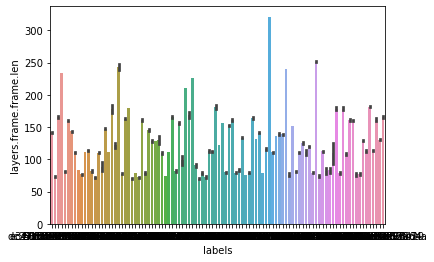

In [ ]:
import seaborn as sb
sb.barplot(data=df, x='labels', y='layers.frame.frame.len')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/Network dataset/probs_aaaaaaabap') as f:
    data = f.readlines()
    data = [json.loads(line) for line in data] #convert string to dict format


In [ ]:
data = [item for i, item in enumerate(data) if i % 2 == 1 ]

In [ ]:
df1 = pd.DataFrame(data)

In [ ]:
df1.head(50)

In [ ]:
df2 = pd.json_normalize(df1['layers'])

AttributeError: ignored

In [ ]:
df1.info

<bound method DataFrame.info of                                                 index  ...                                             layers
0    {'_index': 'packets-2021-06-04', '_type': 'doc'}  ...                                                NaN
1                                                 NaN  ...  {'frame_raw': '000018002e4000a0200800000002800...
2    {'_index': 'packets-2021-06-04', '_type': 'doc'}  ...                                                NaN
3                                                 NaN  ...  {'frame_raw': '000018002e4000a0200800000002800...
4    {'_index': 'packets-2021-06-04', '_type': 'doc'}  ...                                                NaN
..                                                ...  ...                                                ...
995                                               NaN  ...  {'frame_raw': '000018002e4000a0200800000002710...
996  {'_index': 'packets-2021-06-04', '_type': 'doc'}  ...                              

In [ ]:
df2.head()

,frame_raw,radiotap_raw,wlan_raw,frame.frame_frame_interface_id,frame.frame_frame_interface_name,frame.frame_frame_encap_type,frame.frame_frame_time,frame.frame_frame_offset_shift,frame.frame_frame_time_epoch,frame.frame_frame_time_delta,frame.frame_frame_time_delta_displayed,frame.frame_frame_time_relative,frame.frame_frame_number,frame.frame_frame_len,frame.frame_frame_cap_len,frame.frame_frame_marked,frame.frame_frame_ignored,frame.frame_frame_protocols,radiotap.radiotap_radiotap_version_raw,radiotap.radiotap_radiotap_version,radiotap.radiotap_radiotap_pad_raw,radiotap.radiotap_radiotap_pad,radiotap.radiotap_radiotap_length_raw,radiotap.radiotap_radiotap_length,radiotap.radiotap_radiotap_present_raw,radiotap.radiotap_radiotap_present,radiotap.radiotap_radiotap_present_word_raw,radiotap.radiotap_radiotap_present_word,radiotap.radiotap_radiotap_present_tsft_raw,radiotap.radiotap_radiotap_present_tsft,radiotap.radiotap_radiotap_present_flags_raw,radiotap.radiotap_radiotap_present_flags,radiotap.radiotap_radiotap_present_rate_raw,radiotap.radiotap_radiotap_present_rate,radiotap.radiotap_radiotap_present_channel_raw,radiotap.radiotap_radiotap_present_channel,radiotap.radiotap_radiotap_present_fhss_raw,radiotap.radiotap_radiotap_present_fhss,radiotap.radiotap_radiotap_present_dbm_antsignal_raw,radiotap.radiotap_radiotap_present_dbm_antsignal,...,wlan_wlan_mgt.wps_wps_primary_device_type,wlan_wlan_mgt.wps_wps_primary_device_type_category_raw,wlan_wlan_mgt.wps_wps_primary_device_type_category,wlan_wlan_mgt.wps_wps_primary_device_type_subcategory_network_infrastructure_raw,wlan_wlan_mgt.wps_wps_primary_device_type_subcategory_network_infrastructure,wlan_wlan_mgt.wps_wps_device_name_raw,wlan_wlan_mgt.wps_wps_device_name,wlan_wlan_mgt.wps_wps_config_methods_raw,wlan_wlan_mgt.wps_wps_config_methods,wlan_wlan_mgt.wps_wps_config_methods_usba_raw,wlan_wlan_mgt.wps_wps_config_methods_usba,wlan_wlan_mgt.wps_wps_config_methods_ethernet_raw,wlan_wlan_mgt.wps_wps_config_methods_ethernet,wlan_wlan_mgt.wps_wps_config_methods_label_raw,wlan_wlan_mgt.wps_wps_config_methods_label,wlan_wlan_mgt.wps_wps_config_methods_display_raw,wlan_wlan_mgt.wps_wps_config_methods_display,wlan_wlan_mgt.wps_wps_config_methods_virt_display_raw,wlan_wlan_mgt.wps_wps_config_methods_virt_display,wlan_wlan_mgt.wps_wps_config_methods_phy_display_raw,wlan_wlan_mgt.wps_wps_config_methods_phy_display,wlan_wlan_mgt.wps_wps_config_methods_nfcext_raw,wlan_wlan_mgt.wps_wps_config_methods_nfcext,wlan_wlan_mgt.wps_wps_config_methods_nfcint_raw,wlan_wlan_mgt.wps_wps_config_methods_nfcint,wlan_wlan_mgt.wps_wps_config_methods_nfcinf_raw,wlan_wlan_mgt.wps_wps_config_methods_nfcinf,wlan_wlan_mgt.wps_wps_config_methods_pushbutton_raw,wlan_wlan_mgt.wps_wps_config_methods_pushbutton,wlan_wlan_mgt.wps_wps_config_methods_virt_pushbutton_raw,wlan_wlan_mgt.wps_wps_config_methods_virt_pushbutton,wlan_wlan_mgt.wps_wps_config_methods_phy_pushbutton_raw,wlan_wlan_mgt.wps_wps_config_methods_phy_pushbutton,wlan_wlan_mgt.wps_wps_config_methods_keypad_raw,wlan_wlan_mgt.wps_wps_config_methods_keypad,wlan_wlan_mgt._ws_expert.wlan_wlan_tag_length_bad,_ws_malformed._ws_expert._ws_malformed__ws_malformed_expert,_ws_malformed._ws_expert._ws_expert__ws_expert_message,_ws_malformed._ws_expert._ws_expert__ws_expert_severity,_ws_malformed._ws_expert._ws_expert__ws_expert_group
0,000018002e4000a02008000000028009a000bd000000bd...,000018002e4000a02008000000028009a000bd000000bd00,8400ca0198f6218d84c5ce8e5eafc411,0,wlan1,23,2021-06-04T19:13:42.548126821Z,0.000000000,1622834022.548126821,0.000624361,0.000624361,2402.945204999,345501,44,44,False,False,radiotap:wlan_radio:wlan,00,0,00,0,1800,24,2e4000a020080000,None,"[2e4000a0, 20080000]","[0xa000402e, 0x00000820]","[0, 0]","[False, False]","[1, 0]","[True, False]","[1, 0]","[True, False]","[1, 0]","[True, False]","[0, 0]","[False, False]","[1, 1]","[True, True]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
X, X_val, y, y_val = train_test_split(df2.drop('wlan.wlan_wlan_ta', axis='columns'), 
                                      df2['wlan.wlan_wlan_ta'], test_size=0.9, random_state=1)

In [ ]:
X.info

<bound method DataFrame.info of                                              frame_raw  ... _ws_malformed._ws_expert._ws_expert__ws_expert_group
431  000018002e4000a02008000000026c09a000bd000000bd...  ...                                                NaN  
115  000018002e4000a02008000000189e09c000bf000000bf...  ...                                                NaN  
465  000018002e4000a02008000000028a09a000b5000000b5...  ...                                                NaN  
216  000018002e4000a02008000000188509c000bf000000bf...  ...                                                NaN  
264  000018002e4000a02008000000028509a000bd000000bd...  ...                                                NaN  
209  000018002e4000a02008000000028509a000b7000000b7...  ...                                                NaN  
316  000018002e4000a02008000000028509a000bf000000bf...  ...                                                NaN  
384  000018002e4000a0200800000002a309a000c5000000c5...  ...     

In [ ]:
y.head()

431    e4:fb:5d:34:44:b8
115    f4:db:e6:01:0b:e1
465    3e:9e:b6:0c:c0:d3
216                  NaN
264    ce:8e:5e:af:c4:11
Name: wlan.wlan_wlan_ta, dtype: object

In [ ]:
df2['wlan.wlan_wlan_ta']

0      ce:8e:5e:af:c4:11
1      ce:8e:5e:af:c4:11
2      0e:d6:7c:69:ef:0d
3      ce:8e:5e:af:c4:11
4      ce:8e:5e:af:c4:11
             ...        
495                  NaN
496    70:f1:1c:2e:e2:18
497    2e:6e:dc:20:be:a6
498    70:f1:1c:2e:e2:18
499    0e:6d:56:69:54:8e
Name: wlan.wlan_wlan_ta, Length: 500, dtype: object

In [ ]:
df2.columns[150:200]

Index(['wlan.wlan_wlan_fc_type_subtype_raw', 'wlan.wlan_wlan_fc_type_subtype',
       'wlan.wlan_wlan_fc_raw', 'wlan.wlan_wlan_fc',
       'wlan.wlan_wlan_fc_version_raw', 'wlan.wlan_wlan_fc_version',
       'wlan.wlan_wlan_fc_type_raw', 'wlan.wlan_wlan_fc_type',
       'wlan.wlan_wlan_fc_subtype_raw', 'wlan.wlan_wlan_fc_subtype',
       'wlan.wlan_wlan_flags_raw', 'wlan.wlan_wlan_flags',
       'wlan.wlan_wlan_fc_ds_raw', 'wlan.wlan_wlan_fc_ds',
       'wlan.wlan_wlan_fc_tods_raw', 'wlan.wlan_wlan_fc_tods',
       'wlan.wlan_wlan_fc_fromds_raw', 'wlan.wlan_wlan_fc_fromds',
       'wlan.wlan_wlan_fc_frag_raw', 'wlan.wlan_wlan_fc_frag',
       'wlan.wlan_wlan_fc_retry_raw', 'wlan.wlan_wlan_fc_retry',
       'wlan.wlan_wlan_fc_pwrmgt_raw', 'wlan.wlan_wlan_fc_pwrmgt',
       'wlan.wlan_wlan_fc_moredata_raw', 'wlan.wlan_wlan_fc_moredata',
       'wlan.wlan_wlan_fc_protected_raw', 'wlan.wlan_wlan_fc_protected',
       'wlan.wlan_wlan_fc_order_raw', 'wlan.wlan_wlan_fc_order',
       'wlan.wl

In [ ]:
raw_cols = [col for col in df2.columns if 'raw' in col]
df2.drop(raw_cols, axis='columns', inplace=True)

In [ ]:
frame_cols = [col for col in df2.columns if 'frame' in col]
frame_cols = frame_cols[:15]
frame_cols = [w.replace('frame.frame_', '') for w in frame_cols]

In [ ]:
df2.columns = frame_cols + df2.columns[15:].tolist()

In [ ]:
radio_cols = df2.columns[15:77]
radio_cols = [w.replace('radiotap.radiotap_', '') for w in radio_cols]

In [ ]:
df2.columns = df2.columns[:15].tolist() + radio_cols + df2.columns[77:].tolist()

In [ ]:
wlan_radio_cols = df2.columns[77:85]
wlan_radio_cols = [w.replace('wlan_radio.wlan_radio_', '') for w in wlan_radio_cols]

In [ ]:
df2.columns = df2.columns[:77].tolist() + wlan_radio_cols + df2.columns[85:].tolist()

In [ ]:
wlan_dropped_cols = ['wlan.text',
       'wlan.wlan_wlan_ba_control', 'wlan.wlan_wlan_ba_control_ackpolicy',
       'wlan.wlan_wlan_ba_control_ba_type',
       'wlan.wlan_wlan_ba_control_reserved', 'wlan.wlan_wlan_ba_basic_tidinfo',
       'wlan.wlan_wlan_fixed_ssc', 'wlan.wlan_wlan_fixed_ssc_fragment',
       'wlan.wlan_wlan_fixed_ssc_sequence',
       'wlan._ws_expert.wlan_wlan_fc_retry_expert',
       'wlan._ws_expert._ws_expert__ws_expert_message',
       'wlan._ws_expert._ws_expert__ws_expert_severity',
       'wlan._ws_expert._ws_expert__ws_expert_group', 'wlan.wlan_wlan_ra_resolved',
       'wlan.wlan_wlan_addr', 'wlan.wlan_wlan_addr_resolved',
       'wlan.wlan_wlan_ta_resolved', 'wlan.wlan_wlan_da',
       'wlan.wlan_wlan_da_resolved', 'wlan.wlan_wlan_sa',
       'wlan.wlan_wlan_sa_resolved', 'wlan.wlan_wlan_bssid',
       'wlan.wlan_wlan_bssid_resolved']

In [ ]:
df2.drop(wlan_dropped_cols, axis='columns', inplace=True)

In [ ]:
wlan_cols = df2.columns[85:105]
wlan_cols = [w.replace('wlan.wlan_', '') for w in wlan_cols]

In [ ]:
df2.columns = df2.columns[:85].tolist() + wlan_cols + df2.columns[105:].tolist()

In [ ]:
df2.rename(columns={'wlan_ra': 'destination_address', 'wlan_ta': 'source_address'}, inplace=True)

In [ ]:
wlan_mgt_dropped_cols = ['wlan_wlan_mgt.wlan_wlan_tagged_all', 'wlan_wlan_mgt.wlan_wlan_tag', 'wlan_wlan_mgt.wlan_wlan_wfa_ie_type', 'wlan_wlan_mgt.wlan_wlan_ht_capabilities',
          'wlan_wlan_mgt.wlan_wlan_ht_mcsset', 'wlan_wlan_mgt.wlan_wlan_ht_ampduparam', 'wlan_wlan_mgt.wlan_wlan_ht_mcsset_txmaxss', 
          'wlan_wlan_mgt.wlan_wlan_txbf', 'wlan_wlan_mgt.wlan_wlan_vht_capabilities', 'wlan_wlan_mgt.wlan_wlan_vht_mcsset', 'wlan_wlan_mgt.wlan_wlan_vht_mcsset_rxmcsmap',
           'wlan_wlan_mgt.wlan_wlan_vht_mcsset_txmcsmap', 'wlan_wlan_mgt.wlan_wlan_ext_tag', 'wlan_wlan_mgt.wlan_wlan_country_info_fnm', 
          ]

In [ ]:
df2.drop(wlan_mgt_dropped_cols, axis='columns', inplace=True)

In [ ]:
wlan_mgt_cols = df2.columns[105:692]
wlan_mgt_cols = [w.replace('wlan_wlan_mgt.wlan_', '') for w in wlan_mgt_cols]
wlan_mgt_cols = [w.replace('wlan.wlan_', '') for w in wlan_mgt_cols]
wlan_mgt_cols = [w.replace('wlan_ext_tag_', '') for w in wlan_mgt_cols]

In [ ]:
df2.columns = df2.columns[:105].tolist() + wlan_mgt_cols + df2.columns[692:].tolist()

In [ ]:
awdl_cols = df2.columns[792:931]
awdl_cols = [w.replace('awdl.awdl_data_', '') for w in awdl_cols]

In [ ]:
df2.columns = df2.columns[:792].tolist() + awdl_cols + df2.columns[931:].tolist()

In [ ]:
renamed_cols = df2.columns[931:]
renamed_cols = [w.replace('llc.llc_', '') for w in renamed_cols]
renamed_cols = [w.replace('awdl_data.awdl_data_', '') for w in renamed_cols]
renamed_cols = [w.replace('ipv6.ipv6_', '') for w in renamed_cols]
renamed_cols = [w.replace('udp.udp_', '') for w in renamed_cols]
renamed_cols = [w.replace('mdns.dns_', '') for w in renamed_cols]
renamed_cols = [w.replace('wlan_wlan_mgt.wlan_', '') for w in renamed_cols]
renamed_cols = [w.replace('wlan_wlan_mgt.wps_', '') for w in renamed_cols]
renamed_cols = [w.replace('wlan_wlan_mgt.wlan_', '') for w in renamed_cols]
renamed_cols = [w.replace('wlan_wlan_mgt._ws_expert.wlan_', '') for w in renamed_cols]
renamed_cols = [w.replace('wlan_wlan_mgt.wlan_', '') for w in renamed_cols]

In [ ]:
df2.columns = df2.columns[:931].tolist() + renamed_cols

In [ ]:
df1.drop('layers', axis='columns', inplace=True)

In [ ]:
df = pd.concat([df1, df2])

In [ ]:
df.head()

,timestamp,frame_interface_id,frame_interface_name,frame_encap_type,frame_time,frame_offset_shift,frame_time_epoch,frame_time_delta,frame_time_delta_displayed,frame_time_relative,frame_number,frame_len,frame_cap_len,frame_marked,frame_ignored,frame_protocols,radiotap_version,radiotap_pad,radiotap_length,radiotap_present,radiotap_present_word,radiotap_present_tsft,radiotap_present_flags,radiotap_present_rate,radiotap_present_channel,radiotap_present_fhss,radiotap_present_dbm_antsignal,radiotap_present_dbm_antnoise,radiotap_present_lock_quality,radiotap_present_tx_attenuation,radiotap_present_db_tx_attenuation,radiotap_present_dbm_tx_power,radiotap_present_antenna,radiotap_present_db_antsignal,radiotap_present_db_antnoise,radiotap_present_rxflags,radiotap_present_txflags,radiotap_present_xchannel,radiotap_present_mcs,radiotap_present_ampdu,...,wlan_extcap_b72,wlan_extcap_b73,wlan_extcap_b74,wlan_extcap_b75,wlan_extcap_b76,wlan_extcap_b77,wlan_extcap_b78,wlan_extcap_b79,wps_rf_bands,wlan_ap_channel_report_operating_class,wlan_ap_channel_report_channel_list,wps_response_type,wps_uuid_e,wps_manufacturer,wps_model_name,wps_model_number,wps_serial_number,wps_primary_device_type,wps_primary_device_type_category,wps_primary_device_type_subcategory_network_infrastructure,wps_device_name,wps_config_methods,wps_config_methods_usba,wps_config_methods_ethernet,wps_config_methods_label,wps_config_methods_display,wps_config_methods_virt_display,wps_config_methods_phy_display,wps_config_methods_nfcext,wps_config_methods_nfcint,wps_config_methods_nfcinf,wps_config_methods_pushbutton,wps_config_methods_virt_pushbutton,wps_config_methods_phy_pushbutton,wps_config_methods_keypad,wlan_tag_length_bad,_ws_malformed._ws_expert._ws_malformed__ws_malformed_expert,_ws_malformed._ws_expert._ws_expert__ws_expert_message,_ws_malformed._ws_expert._ws_expert__ws_expert_severity,_ws_malformed._ws_expert._ws_expert__ws_expert_group
0,1622834022548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1622834022548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1622834022549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1622834022550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1622834022551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(df.columns)

1047

In [ ]:
df=df.dropna(axis=1,how='all')

In [ ]:
len(df.columns)

1024

In [ ]:
df.head()

,timestamp,frame_interface_id,frame_interface_name,frame_encap_type,frame_time,frame_offset_shift,frame_time_epoch,frame_time_delta,frame_time_delta_displayed,frame_time_relative,frame_number,frame_len,frame_cap_len,frame_marked,frame_ignored,frame_protocols,radiotap_version,radiotap_pad,radiotap_length,radiotap_present_word,radiotap_present_tsft,radiotap_present_flags,radiotap_present_rate,radiotap_present_channel,radiotap_present_fhss,radiotap_present_dbm_antsignal,radiotap_present_dbm_antnoise,radiotap_present_lock_quality,radiotap_present_tx_attenuation,radiotap_present_db_tx_attenuation,radiotap_present_dbm_tx_power,radiotap_present_antenna,radiotap_present_db_antsignal,radiotap_present_db_antnoise,radiotap_present_rxflags,radiotap_present_txflags,radiotap_present_xchannel,radiotap_present_mcs,radiotap_present_ampdu,radiotap_present_vht,...,dns_opt_data,dns_unsolicited,wlan_extcap_b72,wlan_extcap_b73,wlan_extcap_b74,wlan_extcap_b75,wlan_extcap_b76,wlan_extcap_b77,wlan_extcap_b78,wlan_extcap_b79,wps_rf_bands,wlan_ap_channel_report_operating_class,wlan_ap_channel_report_channel_list,wps_response_type,wps_uuid_e,wps_manufacturer,wps_model_name,wps_model_number,wps_serial_number,wps_primary_device_type,wps_primary_device_type_category,wps_primary_device_type_subcategory_network_infrastructure,wps_device_name,wps_config_methods,wps_config_methods_usba,wps_config_methods_ethernet,wps_config_methods_label,wps_config_methods_display,wps_config_methods_virt_display,wps_config_methods_phy_display,wps_config_methods_nfcext,wps_config_methods_nfcint,wps_config_methods_nfcinf,wps_config_methods_pushbutton,wps_config_methods_virt_pushbutton,wps_config_methods_phy_pushbutton,wps_config_methods_keypad,_ws_malformed._ws_expert._ws_expert__ws_expert_message,_ws_malformed._ws_expert._ws_expert__ws_expert_severity,_ws_malformed._ws_expert._ws_expert__ws_expert_group
0,1622834022548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1622834022548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1622834022549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1622834022550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1622834022551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
l = [name for name in df2.columns if 'address' in name]

In [ ]:
raw_packet = df2['wlan_raw'][0]

In [ ]:
from scapy.layers.l2 import Ether
import scapy.layers.dot11

In [ ]:
new_packet = Ether(_pkt=raw_packet)

In [ ]:
type(new_packet)

In [ ]:
print(new_packet.show())

In [ ]:
from scapy.all import Dot11, sniff
                       

ap_list = []

def PacketHandler(packet):
  if packet.type == 0 and packet.subtype == 8:
    if packet.addr2 not in ap_list:
                ap_list.append(packet.addr2)
                print("Access Point MAC: %s with SSID: %s " %(packet.addr2, packet.info))


sniff(iface="wlp2s0", prn = PacketHandler)

In [ ]:
!pip install scapy

     |████████████████████████████████| 1.1MB 5.1MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=c5e0a32d1254700f1e873b1101ac75b5acd16dd759e88613545d06d32cab806a
  Stored in directory: /root/.cache/pip/wheels/31/80/dc/d5fc39b70e1af4f4636356c849de414a76e83a89d8ee9cd78f
Successfully built scapy


In [ ]:
from scapy.all import Dot11, sniff, rdpcap
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame(columns=['ToDS', 'MF', 'WEP', 'src_MAC', 'dest_MAC', 'BSSID', 'Duration_ID', 'Sequence_Control', 'time'])

def parse(frame):
  new_frame = []
  if frame.haslayer(Dot11):
      new_frame.append(frame.FCfield & 0b1 != 0)
      new_frame.append(frame.FCfield & 0b10 != 0)
      new_frame.append(frame.FCfield & 0b01000000 != 0)
      new_frame.append(frame.addr2)
      new_frame.append(frame.addr1)
      new_frame.append(frame.addr3)
      new_frame.append(frame.ID)
      new_frame.append(frame.SC)
      new_frame.append(frame.time)
      df.loc[len(df.index)] = new_frame






      #s1 = pd.Series(new_frame)
      #df.append(s1, ignore_index=True)
      ''' 
      print("ToDS:", frame.FCfield & 0b1 != 0)
      print("MF:", frame.FCfield & 0b10 != 0)
      print("WEP:", frame.FCfield & 0b01000000 != 0)
      print("src MAC:", frame.addr2)
      print("dest MAC:", frame.addr1)
      print("BSSID:", frame.addr3)
      print("Duration ID:", frame.ID)
      print("Sequence Control:", frame.SC)
      print("\n")
      '''


In [ ]:
sniff(offline="/content/drive/MyDrive/Network dataset/ProbeANDrealMAC.pcapng", prn=parse)

<Sniffed: TCP:1168 UDP:221 ICMP:1 Other:34848>

In [ ]:
df.head()

,ToDS,MF,WEP,src_MAC,dest_MAC,BSSID,Duration_ID,Sequence_Control,time
0,False,False,False,9e:1e:21:eb:55:c0,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,0,56976,1622831619.602921822
1,False,False,False,20:e8:82:ea:c5:08,9e:1e:21:eb:55:c0,20:e8:82:ea:c5:08,12289,5888,1622831619.630998863
2,False,False,False,20:e8:82:ea:c5:08,9e:1e:21:eb:55:c0,20:e8:82:ea:c5:08,12289,5904,1622831619.634006955
3,False,False,False,20:e8:82:ea:c5:08,9e:1e:21:eb:55:c0,20:e8:82:ea:c5:08,12289,5920,1622831619.63744804
4,False,False,False,None,20:e8:82:ea:c5:08,None,0,None,1622831619.637753753


In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt


In [ ]:
df['broadcast'] = df['dest_MAC'] == 'ff:ff:ff:ff:ff:ff'

In [ ]:
df.head()

,ToDS,MF,WEP,src_MAC,dest_MAC,BSSID,Duration_ID,Sequence_Control,broadcast
0,False,False,False,74:da:88:47:1b:eb,ff:ff:ff:ff:ff:ff,74:da:88:47:1b:eb,0,8640,True
1,False,False,False,b0:be:76:22:bc:11,ff:ff:ff:ff:ff:ff,b0:be:76:22:bc:11,0,2816,True
2,False,False,False,None,08:5b:d6:9e:36:2b,None,31232,None,False
3,False,False,False,74:da:88:47:1b:eb,08:5b:d6:9e:36:2b,None,0,None,False
4,False,True,True,74:da:88:47:1b:eb,ff:ff:ff:ff:ff:ff,08:5b:d6:9e:36:2b,0,11808,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46125 entries, 0 to 46124
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ToDS              46125 non-null  object
 1   MF                46125 non-null  object
 2   WEP               46125 non-null  object
 3   src_MAC           30485 non-null  object
 4   dest_MAC          46125 non-null  object
 5   BSSID             16898 non-null  object
 6   Duration_ID       46125 non-null  object
 7   Sequence_Control  16898 non-null  object
 8   broadcast         46125 non-null  bool  
dtypes: bool(1), object(8)
memory usage: 4.5+ MB


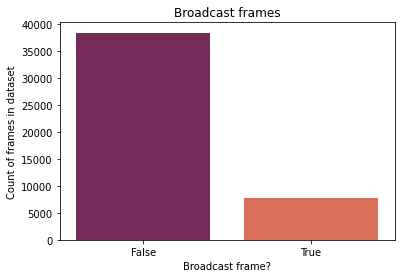

In [ ]:
sb.countplot(data=df, x='broadcast' , palette='rocket')
plt.xlabel('Broadcast frame?')
plt.ylabel('Count of frames in dataset')
plt.title('Broadcast frames');

In [ ]:
df['Source_MAC_available'] = df['src_MAC'].apply(lambda s: s if s is not None else 'XXXX')

In [ ]:
df['Fake_MAC'] = df['Source_MAC_available'].apply(lambda s: s[1])

In [ ]:
df.head()

,ToDS,MF,WEP,src_MAC,dest_MAC,BSSID,Duration_ID,Sequence_Control,broadcast,Fake_MAC,Source_MAC_available
0,False,False,False,74:da:88:47:1b:eb,ff:ff:ff:ff:ff:ff,74:da:88:47:1b:eb,0,8640,True,4,74:da:88:47:1b:eb
1,False,False,False,b0:be:76:22:bc:11,ff:ff:ff:ff:ff:ff,b0:be:76:22:bc:11,0,2816,True,0,b0:be:76:22:bc:11
2,False,False,False,None,08:5b:d6:9e:36:2b,None,31232,None,False,X,XXXX
3,False,False,False,74:da:88:47:1b:eb,08:5b:d6:9e:36:2b,None,0,None,False,4,74:da:88:47:1b:eb
4,False,True,True,74:da:88:47:1b:eb,ff:ff:ff:ff:ff:ff,08:5b:d6:9e:36:2b,0,11808,True,4,74:da:88:47:1b:eb


In [ ]:
df['Fake'] = (df['Fake_MAC'] == '2') + (df['Fake_MAC'] == '6') + (df['Fake_MAC'] == 'A') + (df['Fake_MAC'] == 'E')

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
df['Fake'].value_counts()

False    42440
True      3685
Name: Fake, dtype: int64

In [ ]:
df['human_time'] = df['time'].apply(lambda x: time.asctime(x)
my_human_time = time.strftime('%A, %d/%m/%y, %I:%M:%S %p', local_time)